Num GPUs Available:  1
Training samples: 50000, Validation samples: 10000


Model: "Custom_ResNet_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ sequential[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ dropout_1[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_3[0][0]  

 Total params: 4,337,162 (16.54 MB)

 Trainable params: 4,330,890 (16.52 MB)

 Non-trainable params: 6,272 (24.50 KB)

Epoch 1/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3376 - loss: 1.8725
Epoch 1: val_loss improved from inf to 2.35362, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 82ms/step - accuracy: 0.3377 - loss: 1.8723 - val_accuracy: 0.3516 - val_loss: 2.3536 - learning_rate: 0.0010
Epoch 2/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5259 - loss: 1.3299
Epoch 2: val_loss improved from 2.35362 to 1.99733, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 81ms/step - accuracy: 0.5259 - loss: 1.3298 - val_accuracy: 0.4671 - val_loss: 1.9973 - learning_rate: 0.0010
Epoch 3/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5991 - loss: 1.1451
Epoch 3: val_loss improved from 1.99733 to 1.37138, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 81ms/step - accuracy: 0.5991 - loss: 1.1451 - val_accuracy: 0.5842 - val_loss: 1.3714 - learning_rate: 0.0010
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━

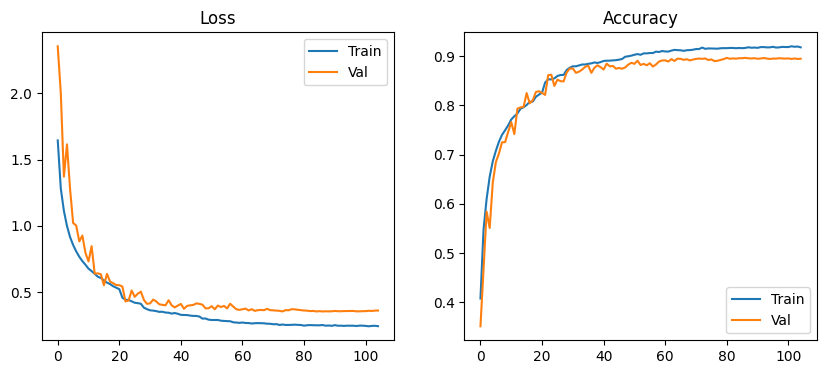

In [ ]:
# Best model (0.3 score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, initializers
import numpy as np
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================================
# 1. Load and preprocess CIFAR-10 data
# ==========================================================
from tensorflow.keras.datasets import cifar10

(x_train_ed, y_train_ed), (x_test_ed, y_test_ed) = cifar10.load_data()

# Normalize pixel values
x_train_ed = x_train_ed.astype("float32") / 255.0
x_test_ed  = x_test_ed.astype("float32") / 255.0

print(f"Training samples: {x_train_ed.shape[0]}, Validation samples: {x_test_ed.shape[0]}")

# ==========================================================
# 2. Data augmentation
# ==========================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomShear(0.1)
])

# ==========================================================
# 3. Residual block definition
# ==========================================================
def residual_block(x, filters, kernel_size, stride, dropout_rate):
    shortcut = x
    # Ensure shortcut is a tensor
    if isinstance(shortcut, tuple):
      shortcut = tf.stack(shortcut, axis=-1) # Or appropriate stacking/concatenation

    # First conv
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second conv
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Adjust shortcut if shape mismatch
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU()(x)
    return x

# ==========================================================
# 4. Model construction
# ==========================================================
initial_filters = 64
num_blocks = 3
num_stages = 3
d_rate = 0.2

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(initial_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

filters = initial_filters

# Stacked residual blocks
for stage in range(num_stages):
    for block in range(num_blocks):
        stride = 2 if stage > 0 and block == 0 else 1
        x = residual_block(x, filters, kernel_size=(3, 3), stride=stride, dropout_rate=d_rate)
    filters *= 2  # double filters for next stage
    d_rate += 0.05

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform',
                       bias_initializer=initializers.Zeros(),
                       kernel_regularizer=regularizers.l2(0.001))(x)

model = keras.Model(inputs, outputs, name="Custom_ResNet_CIFAR10")

# ==========================================================
# 5. Compile the model
# ==========================================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==========================================================
# 6. Train the model
# ==========================================================
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)


history = model.fit(
    x_train_ed, y_train_ed,
    validation_data=(x_test_ed, y_test_ed),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# ==========================================================
# 7. Plot training history
# ==========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Combining datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, initializers
import numpy as np
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Confirm GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# ==========================================================
# 1. Load and preprocess CIFAR-10 data
# ==========================================================
from tensorflow.keras.datasets import cifar10

# Keras data
(x_train_ed, y_train_ed), (x_test_ed, y_test_ed) = cifar10.load_data()

# Kaggle data
data = np.load("cifar_data.npz")
x_train_kag = data["x_train"]
y_train_kag = data["y_train"]
x_test_kag = data["x_test"]

y_train_kag = y_train_kag[:, 1].reshape(-1, 1)

# Combining datasets
x_train_combined = np.concatenate([x_train_ed, x_train_kag], axis=0)
y_train_combined = np.concatenate([y_train_ed, y_train_kag], axis=0)

# Normalize pixel values
x_train_combined = x_train_combined.astype("float32") / 255.0
x_test_ed  = x_test_ed.astype("float32") / 255.0

print(f"Training samples: {x_train_combined.shape[0]}, Validation samples: {x_test_ed.shape[0]}")
print(f"Training samples: {y_train_combined.shape[0]}, Validation samples: {y_test_ed.shape[0]}")

Num GPUs Available:  1
Training samples: 70000, Validation samples: 10000
Training samples: 70000, Validation samples: 10000


Model: "Custom_ResNet_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32, 3) │          0 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │      1,792 │ sequential_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 32, 32,    │          0 │ conv2d_42[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_56[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_57[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 32, 32,    │          0 │ conv2d_44[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_58[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 32,    │          0 │ dropout_18[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 32, 32,    │          0 │ add_18[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │     36,928 │ leaky_re_lu_59[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_60      │ (None, 32, 32,    │          0 │ conv2d_45[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_60[0

 Total params: 4,337,162 (16.54 MB)

 Trainable params: 4,330,890 (16.52 MB)

 Non-trainable params: 6,272 (24.50 KB)

Epoch 1/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3938 - loss: 1.7291
Epoch 1: val_loss improved from inf to 1.92504, saving model to best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.3940 - loss: 1.7287 - val_accuracy: 0.5046 - val_loss: 1.9250 - learning_rate: 0.0010
Epoch 2/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5876 - loss: 1.1736
Epoch 2: val_loss improved from 1.92504 to 1.51272, saving model to best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 128s 234ms/step - accuracy: 0.5876 - loss: 1.1735 - val_accuracy: 0.5924 - val_loss: 1.5127 - learning_rate: 0.0010
Epoch 3/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6638 - loss: 0.9671
Epoch 3: val_loss improved from 1.51272 to 1.39593, saving model to best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 129s 235ms/step - accuracy: 0.6638 - loss: 0.9671 - val_accuracy: 0.6133 - val_loss: 1.3959 - learning_rate: 0.0010
Epoch 4/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 227

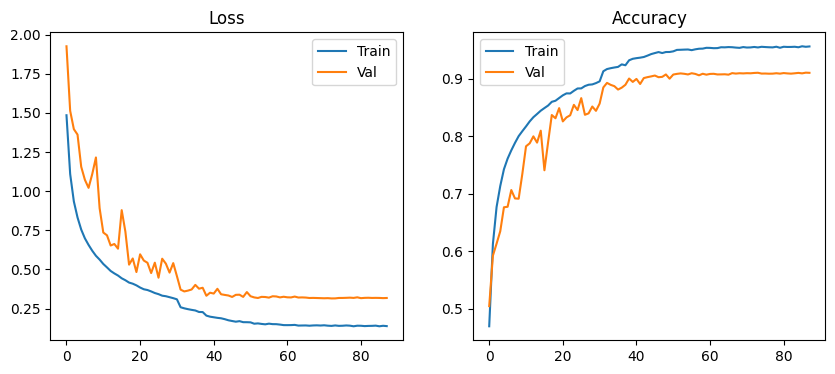

In [ ]:
# Trying stuff

# ==========================================================
# 2. Data augmentation (same as your R code)
# ==========================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomShear(0.1)
])

# ==========================================================
# 3. Residual block definition
# ==========================================================
def residual_block(x, filters, kernel_size, stride, dropout_rate):
    shortcut = x
    # Ensure shortcut is a tensor
    if isinstance(shortcut, tuple):
      shortcut = tf.stack(shortcut, axis=-1) # Or appropriate stacking/concatenation

    # First conv
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    # Second conv
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Adjust shortcut if shape mismatch
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU()(x)
    return x

# ==========================================================
# 4. Model construction
# ==========================================================
initial_filters = 64
num_blocks = 3
num_stages = 3
d_rate = 0.2

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(initial_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

filters = initial_filters

# Stacked residual blocks
for stage in range(num_stages):
    for block in range(num_blocks):
        stride = 2 if stage > 0 and block == 0 else 1
        x = residual_block(x, filters, kernel_size=(3, 3), stride=stride, dropout_rate=d_rate)
    filters *= 2  # double filters for next stage
    d_rate += 0.1

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform',
                       bias_initializer=initializers.Zeros(),
                       kernel_regularizer=regularizers.l2(0.001))(x)

model = keras.Model(inputs, outputs, name="Custom_ResNet_CIFAR10")

# ==========================================================
# 5. Compile the model
# ==========================================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==========================================================
# 6. Train the model
# ==========================================================
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)


history = model.fit(
    x_train_combined, y_train_combined,
    validation_data=(x_test_ed, y_test_ed),
    epochs=200,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# ==========================================================
# 7. Plot training history
# ==========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Getting predictions for test set
import pandas as pd
import numpy as np

x_test_kag = x_test_kag.astype('float32') / 255.0

# Predict probabilities for the test set
prob_resnet = model.predict(x_test_kag)  # shape: (num_samples, 10)

# Convert to DataFrame
prob_df = pd.DataFrame(prob_resnet, columns=[f"Class{i}" for i in range(10)])

# Add ID column (starting after training rows)
prob_df.insert(0, "ID", np.arange(len(x_train_kag) + 1, len(x_train_kag) + len(x_test_kag) + 1))

# Save to CSV
prob_df.to_csv("prob_resnet.csv", index=False)

print("Saved probability predictions to prob_resnet.csv")


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Saved probability predictions to prob_resnet.csv
